In [1]:
from optimization import optimization_restarts_parallel_CG, optimization_restarts_parallel_LBFGS, optimization_restarts_parallel_TNC, gaussian_optimization
from posterior import posterior_distribution_u, posterior_distribution_f
from kernel import gram_Matrix
from create_data import create_data, create_validation_set
import matplotlib.pyplot as plt
import numpy as np
from skopt.space import Real
import jax.numpy as jnp
from plot_lib import plot_prediction

 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\forced_oscillator\create_data.py:19: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\forced_oscillator\create_data.py:28: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


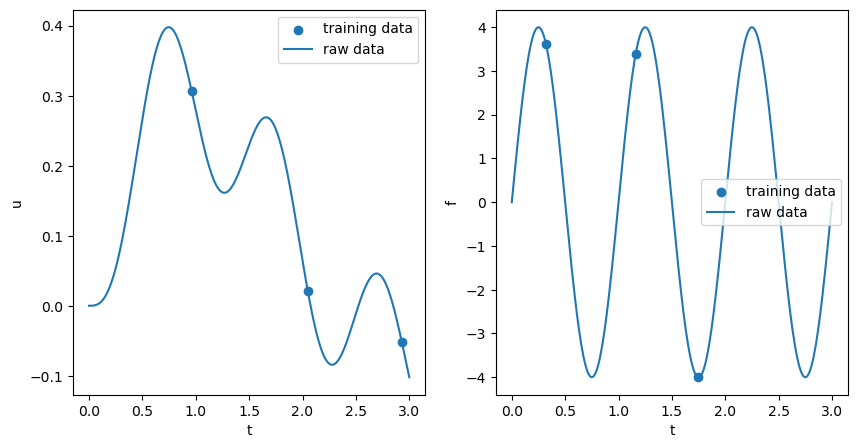

In [26]:
noise = [0.00001,0.00001]
n_training_points = 7
t_u, u, t_f, f, rawdata = create_data("data.csv", n_training_points, noise)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(t_u, u, label="training data")
ax[0].plot(rawdata[0], rawdata[1], label="raw data")
ax[0].set_xlabel("t")
ax[0].set_ylabel("u")
ax[0].legend()
ax[1].scatter(t_f, f, label="training data")
ax[1].plot(rawdata[0], rawdata[2], label="raw data")
ax[1].set_xlabel("t")
ax[1].set_ylabel("f")
ax[1].legend()


In [27]:
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-2.5,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1)) #l
    theta_initial[1] = rng.uniform(0, 2, 1) #sigma
    theta_initial[2] = rng.uniform(0,2,1) #b
    theta_initial[3] = rng.uniform(0, 2, 1) #k
    
    return theta_initial

dictionary_BFGS_CG_TNC = {'theta_initial': get_initial_values,   #needed for all optimization methods
                          'bounds': ((1e-2, None), (1e-2, None), (1e-1, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                          'gtol': 1e-6}

#parameters for the Baysian Optimization
ranges = [Real(1e-1, 3, name='l_x', prior="log-uniform"),
          Real(1e-2, 3, name='sigma_f_sq', prior="uniform"),
          Real(1e-1, 3, name='l_t', prior="log-uniform"),
          Real(1e-1, 4, name='alpha', prior="uniform")]
bays_opt_dictionary = {'dimensions': ranges,
                       'n_calls': 80,
                       'n_initial_points': 20,
                       'verbose': False,
                       'noise': 1e-4,
                       'n_restarts_optimizer': 6,
                       "n_jobs": -1                       
                        }
n_restarts = 200
n_threads = -1
targets = np.concatenate((u,f), axis=0)

In [28]:
tnc = optimization_restarts_parallel_TNC(gram_Matrix,n_restarts,n_threads, dictionary_BFGS_CG_TNC,t_u,t_f,targets,noise)
#lbfgs = optimization_restarts_parallel_LBFGS(gram_Matrix,n_restarts,n_threads, dictionary_BFGS_CG_TNC,t_u,t_f,targets,noise)
#cg = optimization_restarts_parallel_CG(gram_Matrix,n_restarts,n_threads, dictionary_BFGS_CG_TNC,t_u,t_f,targets,noise)

100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


ValueError: min() arg is an empty sequence

In [18]:
#theta = min([tnc,lbfgs,cg], key=lambda x: x.fun).x
t_validation, u_validation, t_validation_f, f_validation = create_validation_set(1000, noise, "data.csv")
theta = tnc.x

t_test = np.linspace(0, 3, 101)
t_star = t_test.reshape(-1,1)

mean_u, var_u = posterior_distribution_u(t_u,t_f,t_star,targets,noise,theta, gram_Matrix)
mean_u = mean_u.flatten()
var_plot = var_u.flatten()
mean_f, var_f = posterior_distribution_f( t_u, t_f, t_star,targets, noise, theta, gram_Matrix)

 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\forced_oscillator\create_data.py:53: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\forced_oscillator\create_data.py:62: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


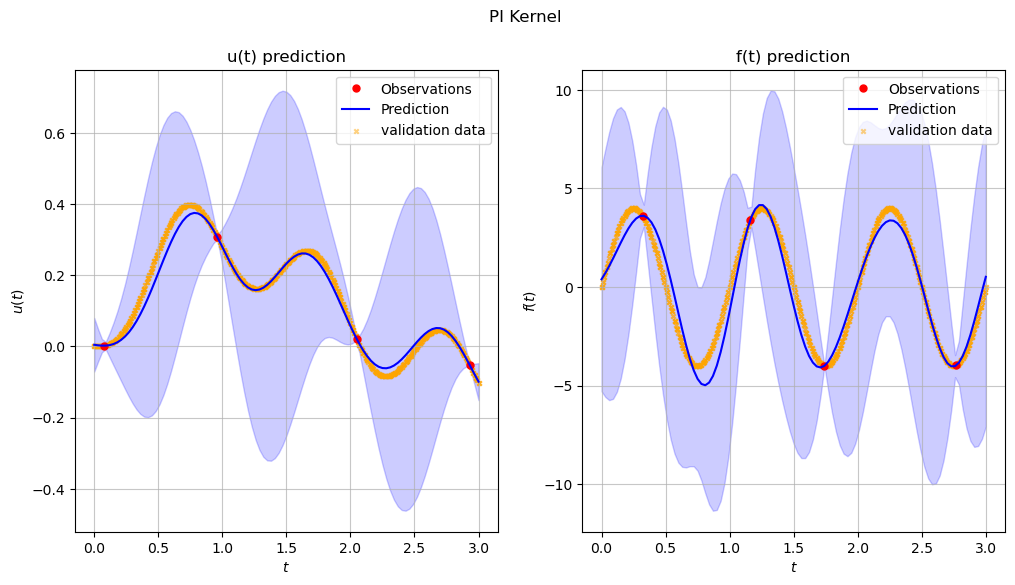

In [19]:
fig,ax = plot_prediction(t_u,u,t_f,f,t_star,mean_u,var_plot,mean_f,var_f,"PI Kernel",savefig=True,filename="TNC.png")
ax[0].scatter(t_validation, u_validation, label="validation data",color="orange", marker="x",alpha=0.5, s=10)
ax[1].scatter(t_validation_f, f_validation, label="validation data",color="orange", marker="x",alpha=0.5, s=10)
ax[0].legend()
ax[1].legend()
plt.show()
plt.close(fig)


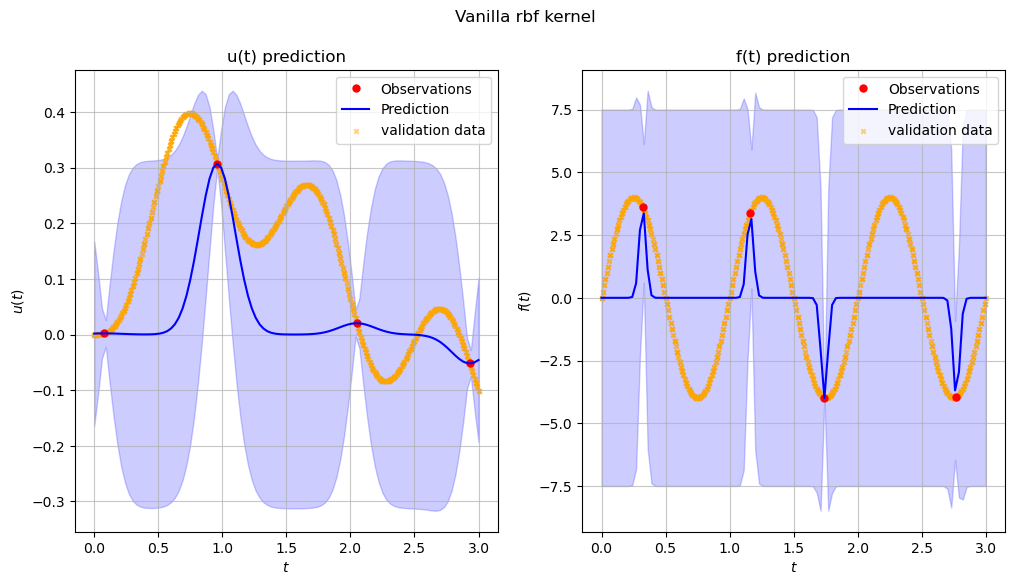

In [20]:
from gpy_lib import use_GPy
m = use_GPy(t_u,u,noise)
mean_u, var_u = m.predict(t_star)
m2 = use_GPy(t_f,f,noise)
mean_f, var_f = m2.predict(t_star)
fig,ax = plot_prediction(t_u,u,t_f,f,t_star,mean_u,var_u,mean_f,var_f,"Vanilla rbf kernel",savefig=True,filename="GPy.png")
ax[0].scatter(t_validation, u_validation, label="validation data", color="orange", marker="x",alpha=0.5, s=10)
ax[1].scatter(t_validation_f, f_validation, label="validation data",color="orange", marker="x",alpha=0.5, s=10)
ax[0].legend()
ax[1].legend()
plt.show()
